In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("../../raw_data/Crimes.csv")

In [3]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
df.drop(columns=["X Coordinate", "Y Coordinate", "Latitude", "Longitude", "Location", "Beat"], inplace=True)

## Community area 25


In [5]:
df_4=df.groupby("Community Area").count()
ca_df=df_4[["ID"]].rename(columns={"ID" : "crime_count" })

In [6]:
worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )
print(f" The worst community area is Nr. {int(worst)}!")

 The worst community area is Nr. 25!


/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_84920/1255772045.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )


In [7]:
df_25=df[df["Community Area"]==worst]

In [8]:
from datetime import datetime

def timer(t):
    return datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p")

In [9]:
df_25["Date_dt"]=df_25["Date"].apply(timer)

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_84920/3525700377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Date_dt"]=df_25["Date"].apply(timer)


In [10]:
df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_84920/620581492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_M"]=df_25['Date_dt'].dt.to_period('M')


In [11]:
ca25monthly_df=df_25.groupby("Y_M").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

In [12]:
ca25monthly_df

,crime_count
Y_M,
2001-01,33
2001-02,18
2001-03,16
2001-04,16
2001-05,16
...,...
2024-04,1017
2024-05,1101
2024-06,1225


<Axes: xlabel='Y_M'>

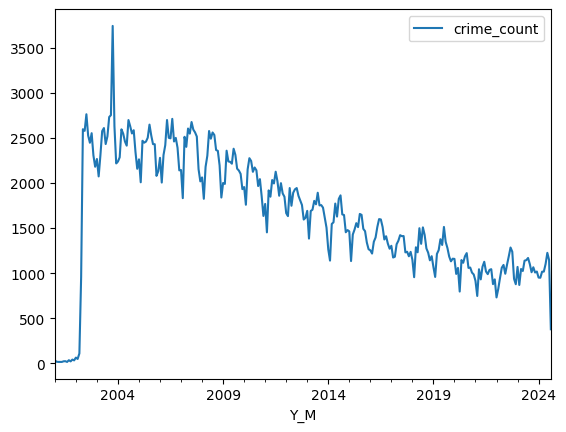

In [13]:
ca25monthly_df.plot()

## RNN model 1

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [142]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25monthly_df["crime_count"])

# parameters
sequence_length = 12  # number of months to consider for predicting the next months

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [143]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [144]:
X_train_scaled=scaler.transform(X_train)

In [145]:
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [146]:
from tensorflow.keras.callbacks import EarlyStopping

In [177]:
# 1- RNN Architecture

model = Sequential()

model.add(layers.Con(units=100, activation='relu', input_shape=(sequence_length,1), return_sequences=True))
#model.add(Dropout(0.1))

model.add(layers.GRU(units=100, activation='relu'))
#model.add(Dropout(0.2))

model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=500, verbose=0, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

/Users/user/.pyenv/versions/3.10.6/envs/LW_chicago_crime_pred/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


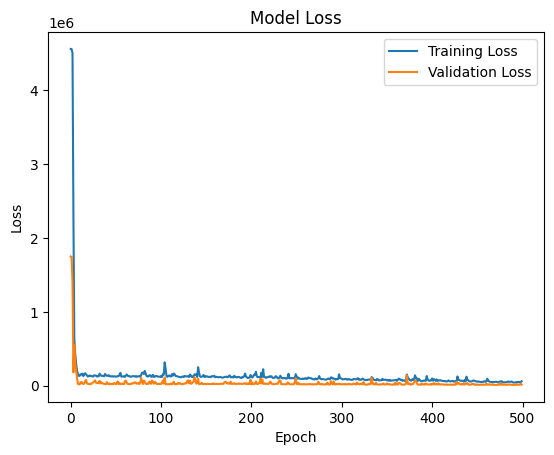

In [178]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [179]:
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)

-0.8485814332962036

# TRY WEEKLY FORECAST

In [18]:
df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_84920/1990554854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25["Y_W"]=df_25['Date_dt'].dt.to_period('W')


In [19]:
ca25weekly_df=df_25.groupby("Y_W").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

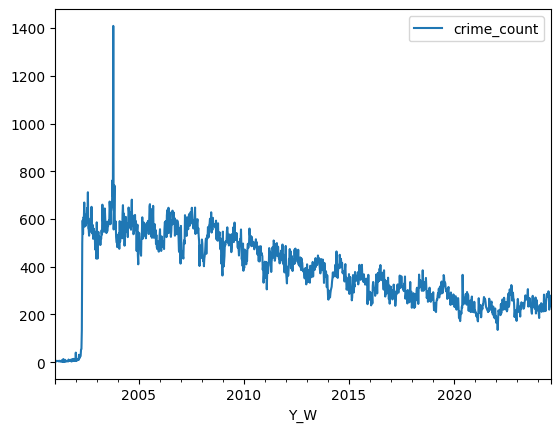

In [20]:
ca25weekly_df.plot();

In [21]:
ca25weekly_df.shape

(1231, 1)

In [38]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25weekly_df["crime_count"])

# parameters
sequence_length = 52  # number of weeks to consider for predicting the next week

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split 
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [40]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [51]:
# NN Architecture (CNN + RNN + Dense)

model = Sequential()

model.add(layers.Conv1D( filters=64, kernel_size=52, input_shape=(52, 1) ) )
#model.add(Dropout(0.1))

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mae', 
              optimizer=Adam(learning_rate=0.001)) 

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=200, verbose=1, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

# 4- Predict
y_pred=model.predict(X_test_scaled) 

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 476.9905 - val_loss: 290.4287
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 445.1657 - val_loss: 174.5073
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 196.5117 - val_loss: 28.3470
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.0483 - val_loss: 29.5089
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.0358 - val_loss: 30.8680
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.9964 - val_loss: 31.1438
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50.9935 - val_loss: 28.8739
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.1389 - val_loss: 30.3919
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.2453 - val_loss: 31.1118
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.0250 - val_loss: 32.6947
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0274 - val_loss: 29.4154
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━

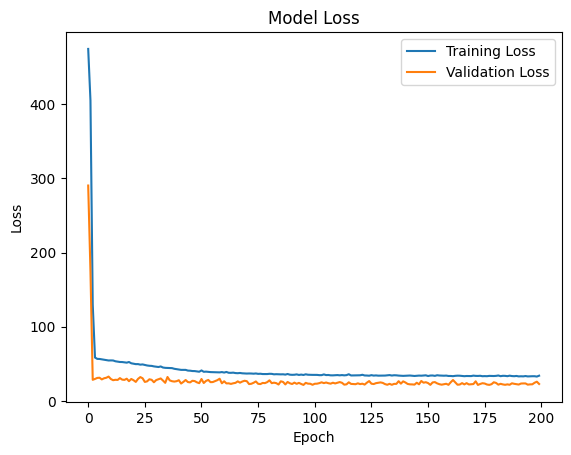

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

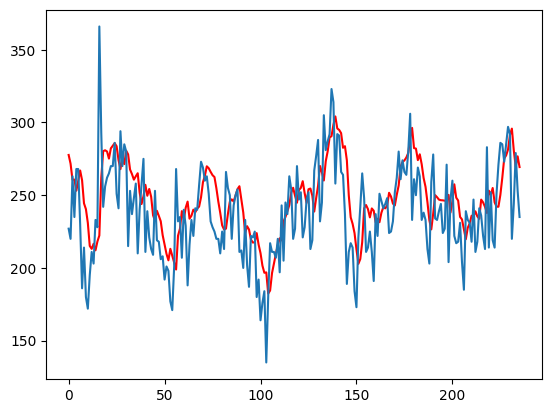

In [58]:
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.plot(pd.DataFrame(y_test))

In [59]:
history.history

{'loss': [474.7258605957031,
  404.95404052734375,
  129.76412963867188,
  58.37961196899414,
  56.559959411621094,
  56.46177291870117,
  55.94199752807617,
  55.39613723754883,
  55.0482292175293,
  54.39726638793945,
  54.50442123413086,
  54.404964447021484,
  53.34479904174805,
  52.82931137084961,
  52.367393493652344,
  52.30129623413086,
  51.82316970825195,
  51.4828987121582,
  52.35222625732422,
  50.63380813598633,
  50.022254943847656,
  49.484107971191406,
  49.52450942993164,
  48.789344787597656,
  49.0937385559082,
  48.35541534423828,
  47.67223358154297,
  47.2633056640625,
  47.10172653198242,
  46.43793487548828,
  46.054718017578125,
  45.597320556640625,
  46.352561950683594,
  44.91529846191406,
  44.47026824951172,
  44.307865142822266,
  44.05855941772461,
  44.08766555786133,
  43.197513580322266,
  42.754722595214844,
  42.29996109008789,
  41.7364616394043,
  41.68880844116211,
  41.72956085205078,
  40.78562545776367,
  40.62028121948242,
  40.175594329833

__FINAL REMARK/QUESTION: SHOULD HAVE SCALED THE y's AS WELL !?!?!__